# Invert Stommel-Munk model using SOR method
**23 April 2021 by MiniUFO**

---
[TOC]

---

## 1. Introduction
The classical wind-driven ocean circulation models are the Stommel-Munk model ([**Stommel 1948**](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/TR029i002p00202); [**Munk 1950**](https://journals.ametsoc.org/view/journals/atsc/7/2/1520-0469_1950_007_0080_otwdoc_2_0_co_2.xml)).  The model is about the horizontal streamfunction $\psi$ of the surface ocean circulation in response to wind-stress curl $\vec{k}\cdot\nabla \times \vec{\tau}$, which can be written as:
>$$
\begin{equation}
A_4\nabla^4\psi - A_2\nabla^2\psi - \beta\frac{\partial\psi}{\partial x} = - \frac{\vec{k}\cdot\nabla \times \vec{\tau}}{\rho_0D} \label{Eq1}\tag{1}
\end{equation}
$$

If $A_4=0$ ($A_2\neq 0$), then Eq. ($\ref{Eq1}$) reduces to the Stommel (1948) model, which is a second-order partial differential equation about $\psi$; If $A_2=0$ ($A_4\neq 0$), Eq. ($\ref{Eq1}$) reduces to the Munk (1950) model, which is the fourth-order partial differential equation.  Therefore, Eq. ($\ref{Eq1}$) is also called Stommel-Munk model.  Given the wind-stress curl $\vec{k}\cdot\nabla \times \vec{\tau}$, or the wind stress $\tau$ itself, one can invert the horizonal streamfunction using the SOR iteration.


## 2. Theory
Here the derivation of the Stommel-Munk model is briefly reviewed.  The start point is the horizontal momentum equation in vector form:
>$$
\begin{equation}
\frac{\partial \vec{u}}{\partial t}=-(\vec{u}\cdot\nabla)\vec{u}-\frac{1}{\rho}\nabla p-f\vec{k}\times \vec{u}+\frac{\partial \vec{T}}{\partial z}+A_4\nabla^2 \vec{u} \label{Eq2}\tag{2}
\end{equation}
$$

where $\vec{T}$ is the stress.  Taking the curl $\vec{k}\cdot\nabla\times()$ of both sides of Eq. ($\ref{Eq2}$) gives the vorticity ($\zeta$) equation:
>$$
\begin{equation}
\frac{\partial \zeta}{\partial t}=-\vec{u}\cdot\nabla\zeta-(\zeta+f)\nabla\cdot \vec{u}-v\beta+\frac{\partial }{\partial z}(\vec{k}\cdot\nabla\times \vec{T})+A_4\nabla^2 \zeta \label{Eq3}\tag{3}
\end{equation}
$$

Assuming steady-state (drop first term), linear (drop second term), and nondivergent (drop the third term), one has:
>$$
\begin{equation}
A_4\nabla^2 \zeta-v\beta+\frac{\partial }{\partial z}(\vec{k}\cdot\nabla\times \vec{T})=0 \label{Eq4}\tag{4}
\end{equation}
$$

Assume that flow is vertically uniform within the mixed layer, and that at the surface $\vec{T}\vert_{sfc}=\vec{\tau}/\rho_0$ and at the bottom of the mixed layer $\vec{T}\vert_{btm}=R\vec{u}$ (linear drag or Newtonian cooling), Eq. ($\ref{Eq4}$) becomes:
>$$
\begin{equation}
A_4\nabla^2 \zeta-v\beta+\frac{(\vec{k}\cdot\nabla\times \vec{\tau}/\rho_0-R\zeta)}{D}=0 \label{Eq5}\tag{5}
\end{equation}
$$

After some arrangements, and introducing the streamfunction $\zeta=\nabla^2\psi$, it becomes the Stommel-Munk model:
>$$
\begin{equation}
A_4\nabla^4 \psi-\frac{R}{D}\nabla^2\psi-\beta\frac{\partial \psi}{\partial x}=-\frac{\vec{k}\cdot\nabla\times \vec{\tau}}{\rho_0D} \label{Eq6}\tag{6}
\end{equation}
$$

Here $A_4$ is the biharmonic diffusion coefficient for the streamfunction (i.e., harmonic diffusion coefficient for the momentum), $R$ the linear damping coefficient, $D$ the mixed-layer depth, and $\rho_0$ the constant reference density of seawater.

## 3. Examples
### 3.1 The classical Stommel example
[**Stommel (1948)**](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/TR029i002p00202) has demonstrated that given a meridionally-varying wind-stress profile, with zero stress at the mid-basin, one will get a symmetric ocean circulation on an $f$-plane, and a western-intensified circulation on a $\beta$ plane.  This can be reproduced by the following code.

In [2]:
### classical cases ###
import sys
sys.path.append('../../')
import numpy as np
import xarray as xr
from xinvert.xinvert import invert_Stommel

xnum = 201
ynum = 151
Lx = 1e7 # 10,000 km
Ly = 2 * np.pi * 1e6 # 6249 km
R = 0.0008 # Rayleigh friction
depth = 200 # fluid depth 200
beta = 1.8e-11
F = 0.3

xdef = xr.DataArray(np.linspace(0, Lx, xnum), dims='xdef',
                    coords={'xdef':np.linspace(0, Lx, xnum)})
ydef = xr.DataArray(np.linspace(0, Ly, ynum), dims='ydef',
                    coords={'ydef':np.linspace(0, Ly, ynum)})

ygrid, xgrid = xr.broadcast(ydef, xdef)

tau_ideal = xr.DataArray(-F * np.cos(np.pi * ygrid / Ly),
                         dims=['ydef','xdef'],
                         coords={'ydef':ydef, 'xdef':xdef})

# finite difference for curl
curl_tau = - tau_ideal.differentiate('ydef')

Inverting for the ocean circulation in terms of the streamfunction $\psi$ and wind field ($u$, $v$), within lat/lon plane, is as simple as:

In [3]:
### inversion ###
s1, u1, v1 = invert_Stommel(curl_tau, dims=['ydef','xdef'], BCs=['fixed', 'fixed'],
                            cal_flow=True, optArg=1.9, mxLoop=3000,
                            coords='cartesian', beta=0, R=R, depth=depth, undef=np.nan)
s2, u2, v2 = invert_Stommel(curl_tau, dims=['ydef','xdef'], BCs=['fixed', 'fixed'],
                            cal_flow=True, optArg=1.9, mxLoop=3000,
                            coords='cartesian', beta=beta, R=R, depth=depth, undef=np.nan)

{} loops 2887 and tolerance is 9.975332e-12
{} loops  455 and tolerance is 8.476830e-12


The result can be visualized as:

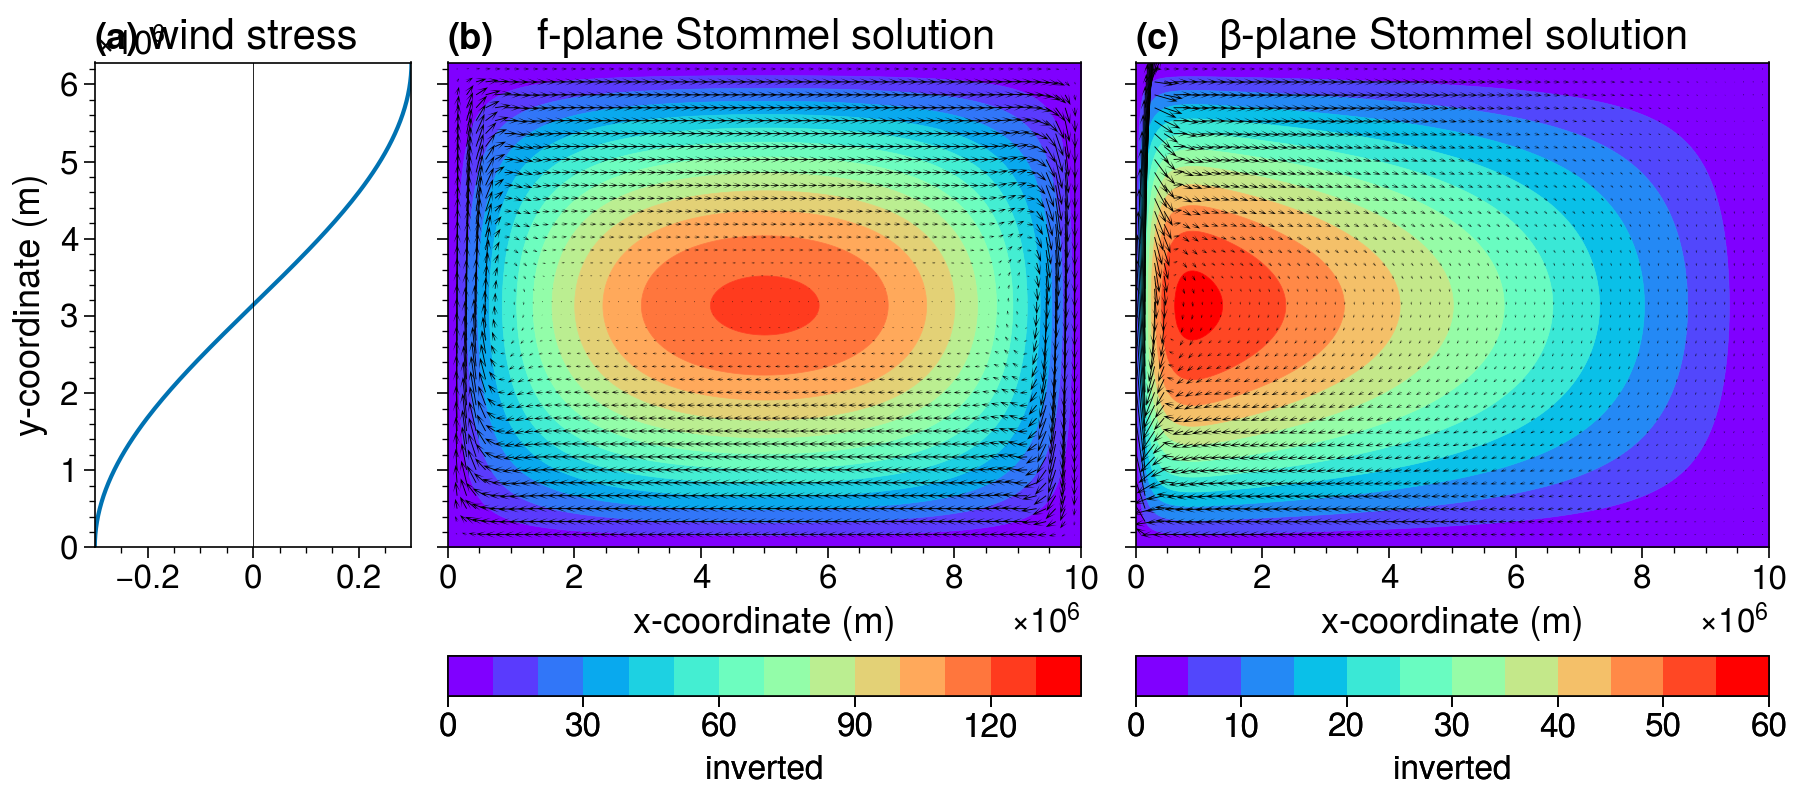

In [8]:
import proplot as pplt
%matplotlib inline

array = [
    [1, 2, 2, 3, 3,],
    ]

fig, axes = pplt.subplots(array, figsize=(9,4), sharex=0, sharey=3)

skip = 3
fontsize = 15

ax = axes[0]
ax.plot(tau_ideal[:,0], tau_ideal.ydef)
ax.plot(tau_ideal[:,0]-tau_ideal[:,0], tau_ideal.ydef, color='k', linewidth=0.3)
ax.set_ylabel('y-coordinate (m)', fontsize=fontsize-2)
ax.set_title('wind stress', fontsize=fontsize)

ax = axes[1]
m=ax.contourf(s1/1e6*depth, cmap='rainbow', levels=np.linspace(0, 140, 15))
ax.set_title('$f$-plane Stommel solution', fontsize=fontsize)
p=ax.quiver(xgrid.values[::skip+1,::skip], ygrid.values[::skip+1,::skip],
              u1.values[::skip+1,::skip], v1.values[::skip+1,::skip],
              width=0.0014, headwidth=8., headlength=12., scale=10)
ax.colorbar(m, loc='b')
ax.set_ylim([0, Ly])
ax.set_xlim([0, Lx])
ax.set_xlabel('x-coordinate (m)', fontsize=fontsize-2)
ax.set_ylabel('y-coordinate (m)', fontsize=fontsize-2)

ax = axes[2]
m=ax.contourf(s2/1e6*depth, cmap='rainbow', levels=np.linspace(0, 60, 13))
ax.set_title('$\\beta$-plane Stommel solution', fontsize=fontsize)
ax.quiver(xgrid.values[::skip+1,::skip], ygrid.values[::skip+1,::skip],
              u2.values[::skip+1,::skip], v2.values[::skip+1,::skip],
              width=0.0014, headwidth=8., headlength=12., scale=8)
              # headwidth=1, headlength=3, width=0.002)
ax.colorbar(m, loc='b')
ax.set_ylim([0, Ly])
ax.set_xlim([0, Lx])
ax.set_xlabel('x-coordinate (m)', fontsize=fontsize-2)
ax.set_ylabel('y-coordinate (m)', fontsize=fontsize-2)


axes.format(abc='(a)', grid=False, ylabel='y-coordinate (m)')

It is clear that on the $\beta$-plane there is an intensification of the circulation.

### 3.2 The classical Munk example
[**Munk (1950)**](https://journals.ametsoc.org/view/journals/atsc/7/2/1520-0469_1950_007_0080_otwdoc_2_0_co_2.xml) modified Stommel's model by adding a lateral diffusion term and dropping the bottom linear-drag friction.  We are going to reproduce the above example using Munk model by adding a biharmonic coefficient `AH` and setting the bottom linear drag coefficient `R` to zero.  This is as simple as:

In [7]:
from xinvert.xinvert import invert_StommelMunk


h1, u1, v1 = invert_StommelMunk(curl_tau, dims=['ydef','xdef'], BCs=['fixed', 'fixed'],
                                optArg=1, mxLoop=4000, cal_flow=True, coords='cartesian',
                                AH=5e3, # visocity of momentum
                                beta=0,
                                R=0, # no bottom linear drag
                                depth=depth)
h2, u2, v2 = invert_StommelMunk(curl_tau, dims=['ydef','xdef'], BCs=['fixed', 'fixed'],
                                optArg=1, mxLoop=4000, tolerance=1e-14, cal_flow=True, coords='cartesian',
                                AH=5e3, # visocity of momentum
                                beta=beta,
                                R=0, # no bottom linear drag
                                depth=depth)

{} loops 4000 and tolerance is 2.448634e-04
{} loops 4000 and tolerance is 2.021915e-06


Results can be plotted as:

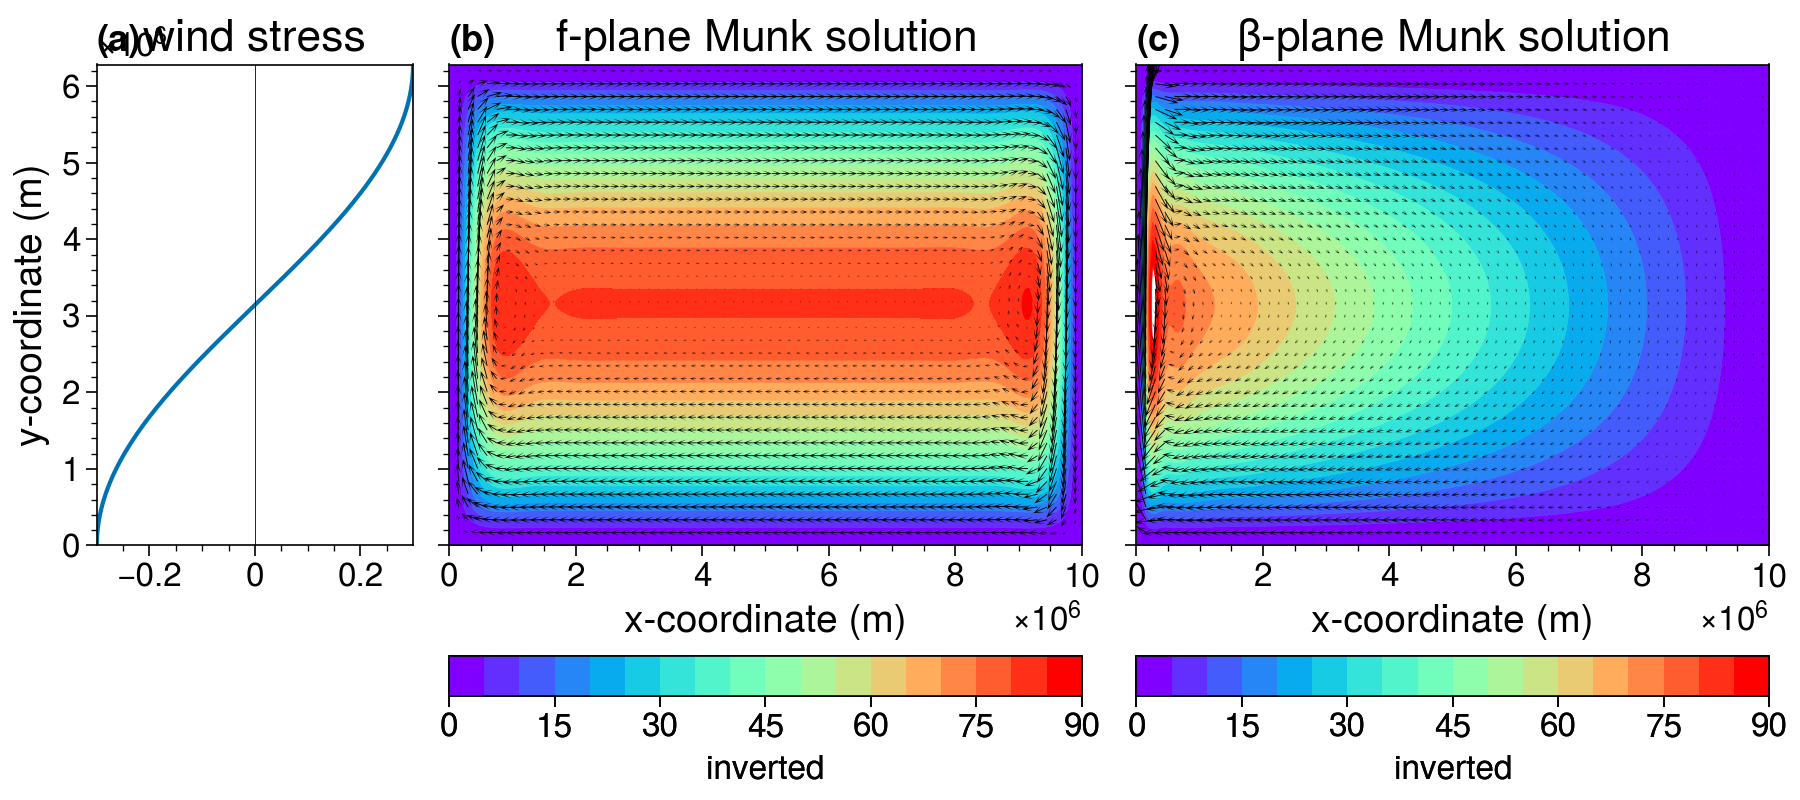

In [10]:
array = [[1, 2, 2, 3, 3,],]

fig, axes = pplt.subplots(array, figsize=(9,4),
                          sharex=0, sharey=3)

skip = 3
fontsize = 16

ax = axes[0]
ax.plot(tau_ideal[:,0], tau_ideal.ydef)
ax.plot(tau_ideal[:,0]-tau_ideal[:,0], tau_ideal.ydef, color='k', linewidth=0.3)
ax.set_ylabel('y-coordinate (m)', fontsize=fontsize-2)
ax.set_title('wind stress', fontsize=fontsize)

ax = axes[1]
m=ax.contourf(h1/1e6*depth, cmap='rainbow', levels=np.linspace(0, 90, 19))
ax.set_title('$f$-plane Munk solution', fontsize=fontsize)
p=ax.quiver(xgrid.values[::skip+1,::skip], ygrid.values[::skip+1,::skip],
              u1.values[::skip+1,::skip], v1.values[::skip+1,::skip],
              width=0.0014, headwidth=8., headlength=12., scale=10)
ax.colorbar(m, loc='b')
ax.set_ylim([0, Ly])
ax.set_xlim([0, Lx])
ax.set_xlabel('x-coordinate (m)', fontsize=fontsize-2)
ax.set_ylabel('y-coordinate (m)', fontsize=fontsize-2)

ax = axes[2]
m=ax.contourf(h2/1e6*depth, cmap='rainbow', levels=np.linspace(0, 90, 19))
ax.set_title('$\\beta$-plane Munk solution', fontsize=fontsize)
ax.quiver(xgrid.values[::skip+1,::skip], ygrid.values[::skip+1,::skip],
              u2.values[::skip+1,::skip], v2.values[::skip+1,::skip],
              width=0.0014, headwidth=8., headlength=12., scale=8)
              # headwidth=1, headlength=3, width=0.002)
ax.colorbar(m, loc='b')
ax.set_ylim([0, Ly])
ax.set_xlim([0, Lx])
ax.set_xlabel('x-coordinate (m)', fontsize=fontsize-2)
ax.set_ylabel('y-coordinate (m)', fontsize=fontsize-2)

axes.format(abc='(a)', grid=False, ylabel='y-coordinate (m)')

The Munk layer at western part of Fig. c is clear.

### 3.3 The realistic example using full Stommel-Munk model

Now we are moving onto a more realistic case: using the climatological wind stress and topography data to calculate the wind-driven circulation over the global ocean.  First loading the data:

In [11]:
#%% real cases
from xgrads.xgrads import open_CtlDataset
from GeoApps.GridUtils import add_latlon_metrics
from GeoApps.DiagnosticMethods import Dynamics

depth = 100
rho0 = 1027
R = 1e-4

# load in wind stress from SODA product
ds = open_CtlDataset('D:/Data/SODA/2.2.6/SODA226Clim_1993_2003.ctl')

dset, grid = add_latlon_metrics(ds)

# calculate wind-stress curl
dyn = Dynamics(dset, grid)

# Climatology for January
tau_real = dyn.curl(dset.taux.where(dset.taux!=dset.undef),
                    dset.tauy.where(dset.taux!=dset.undef))[0].load()

Then invert using the Stommel-Munk model:

In [12]:
# inversion for streamfunction and flow vector
h1, u1, v1 = invert_StommelMunk(tau_real, dims=['lat','lon'], BCs=['fixed', 'periodic'],
                                optArg=1, mxLoop=4000, cal_flow=True,
                                depth=depth, R=R, rho=rho0, AH=3e3)

{} loops 4000 and tolerance is 5.002384e-05


Finally, plot the results:

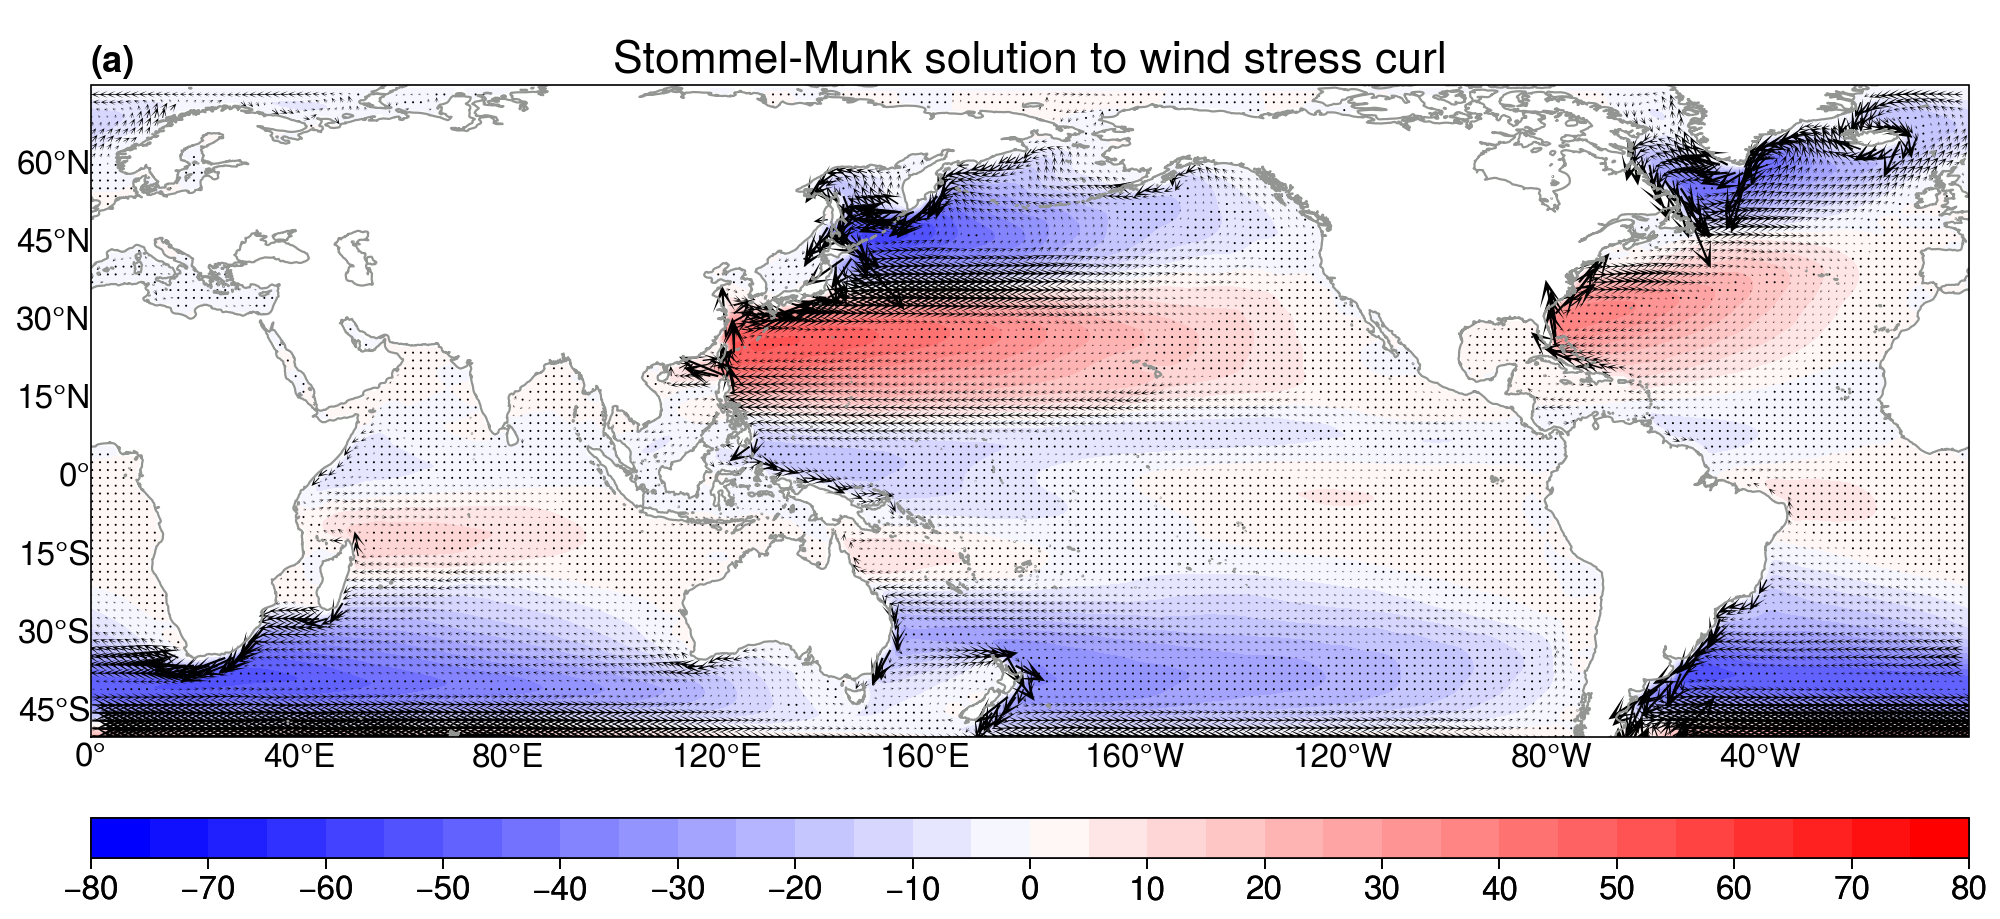

In [16]:
#%%
lat, lon = xr.broadcast(u1.lat, u1.lon)

fig, axes = pplt.subplots(nrows=1, ncols=1, figsize=(10, 4.6), sharex=3, sharey=3, proj=pplt.Proj('cyl', lon_0=180))

skip = 3
fontsize = 16

axes.format(abc='(a)', coast=True, lonlines=40, latlines=15, lonlabels='b', latlabels='l', grid=False, labels=False)

ax = axes[0]
p=ax.contourf(h1/1e6*depth, cmap='bwr', levels=np.linspace(-80,80,33))
ax.set_title('Stommel-Munk solution to wind stress curl', fontsize=fontsize)
ax.quiver(lon.values[::skip,::skip], lat.values[::skip,::skip],
              u1.values[::skip,::skip], v1.values[::skip,::skip],
              width=0.0012, headwidth=10., headlength=12., scale=70)
              # headwidth=1, headlength=3, width=0.002)
ax.set_ylim([-50, 75])
ax.set_xlim([-180, 180])

ax.colorbar(p, loc='b', label='', ticks=10, length=1)

It is clear that much of the observed features are reproduced by the simple model, including the western boundary currents, double-gyre circulations, ACC etc.  We enlarge the part over the western North Pacific for a clearer view:

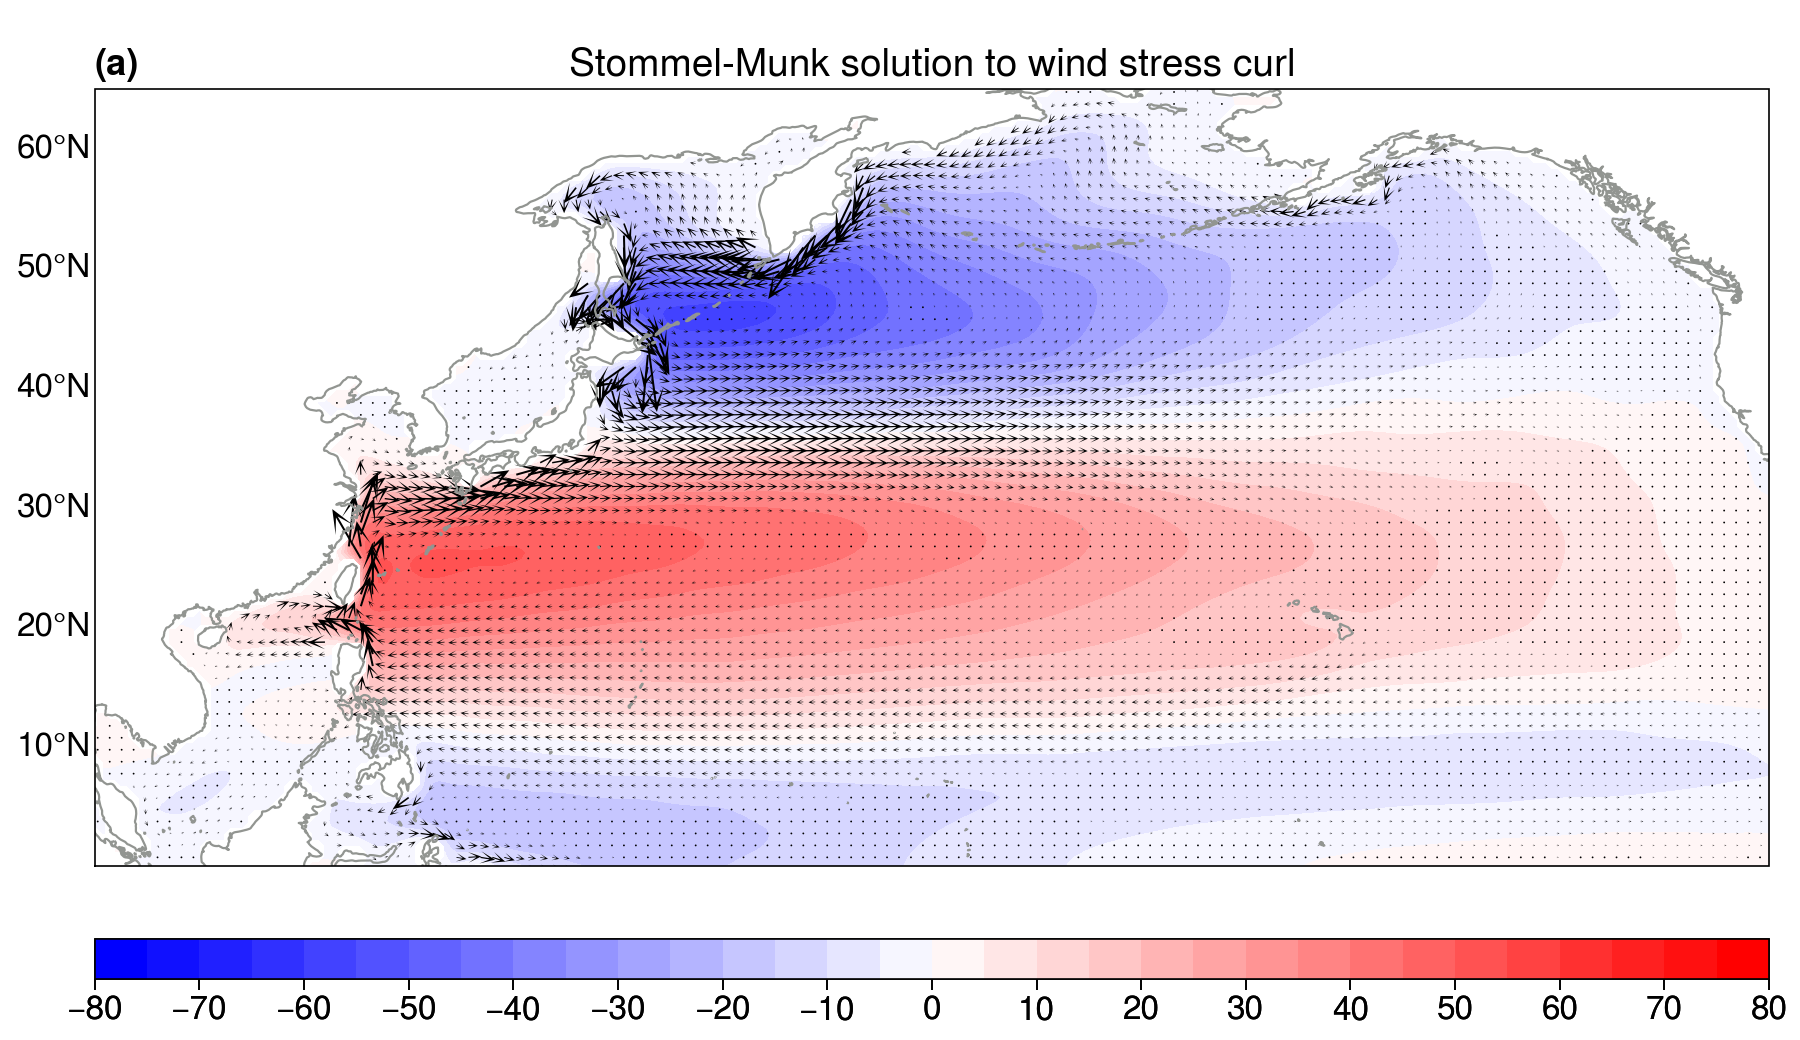

In [23]:
fig, axes = pplt.subplots(nrows=1, ncols=1, figsize=(9, 5.2), sharex=3, sharey=3, proj=pplt.Proj('cyl', lon_0=180))

skip = 2
fontsize = 14

axes.format(abc='(a)', coast=True, lonlines=40, latlines=10, lonlabels='', latlabels='l', grid=False, labels=False)

ax = axes[0]
p=ax.contourf(h1/1e6*depth, cmap='bwr', levels=np.linspace(-80,80,33))
ax.set_title('Stommel-Munk solution to wind stress curl', fontsize=fontsize)
ax.quiver(lon.values[::skip,::skip], lat.values[::skip,::skip],
              u1.values[::skip,::skip], v1.values[::skip,::skip],
              width=0.0012, headwidth=10., headlength=12., scale=80)
              # headwidth=1, headlength=3, width=0.002)
ax.set_ylim([-0, 65])
ax.set_xlim([-80, 60])

ax.colorbar(p, loc='b', label='', ticks=10, length=1)

We can also perform calculations using wind stress in different seasons, as well as spatial-varying bottom friction $R$ that is larger at higher latitudes (so that the ACC transport is reduced somewhat).

In [24]:
# spatial-varying bottom friction
R = 2e-4 * (2 - 1*np.cos(np.deg2rad(lat)))

ds = open_CtlDataset('D:/Data/SODA/2.2.6/SODA226Clim_1993_2003.ctl')

dset, grid = add_latlon_metrics(ds)

dyn = Dynamics(dset, grid)

# loading climatological January
tauxJan = dset.taux.where(dset.taux!=dset.undef)[0]
tauyJan = dset.tauy.where(dset.tauy!=dset.undef)[0]

curl_Jan = dyn.curl(tauxJan, tauyJan).load()

# loading climatological July
tauxJul = dset.taux.where(dset.taux!=dset.undef)[6]
tauyJul = dset.tauy.where(dset.tauy!=dset.undef)[6]

curl_Jul = dyn.curl(tauxJul, tauyJul).load()

# inversion
h1, u1, v1 = invert_StommelMunk(curl_Jan, dims=['lat','lon'], BCs=['fixed', 'periodic'],
                                optArg=1, mxLoop=4000, cal_flow=True,
                                depth=depth, R=R, rho=rho0, AH=3e3)
h2, u2, v2 = invert_StommelMunk(curl_Jul, dims=['lat','lon'], BCs=['fixed', 'periodic'],
                                optArg=1, mxLoop=4000, cal_flow=True,
                                depth=depth, R=R, rho=rho0, AH=3e3)

{} loops 4000 and tolerance is 2.008276e-05
{} loops 4000 and tolerance is 3.805606e-05


Comparing the wind-driven patterns in different seasons:

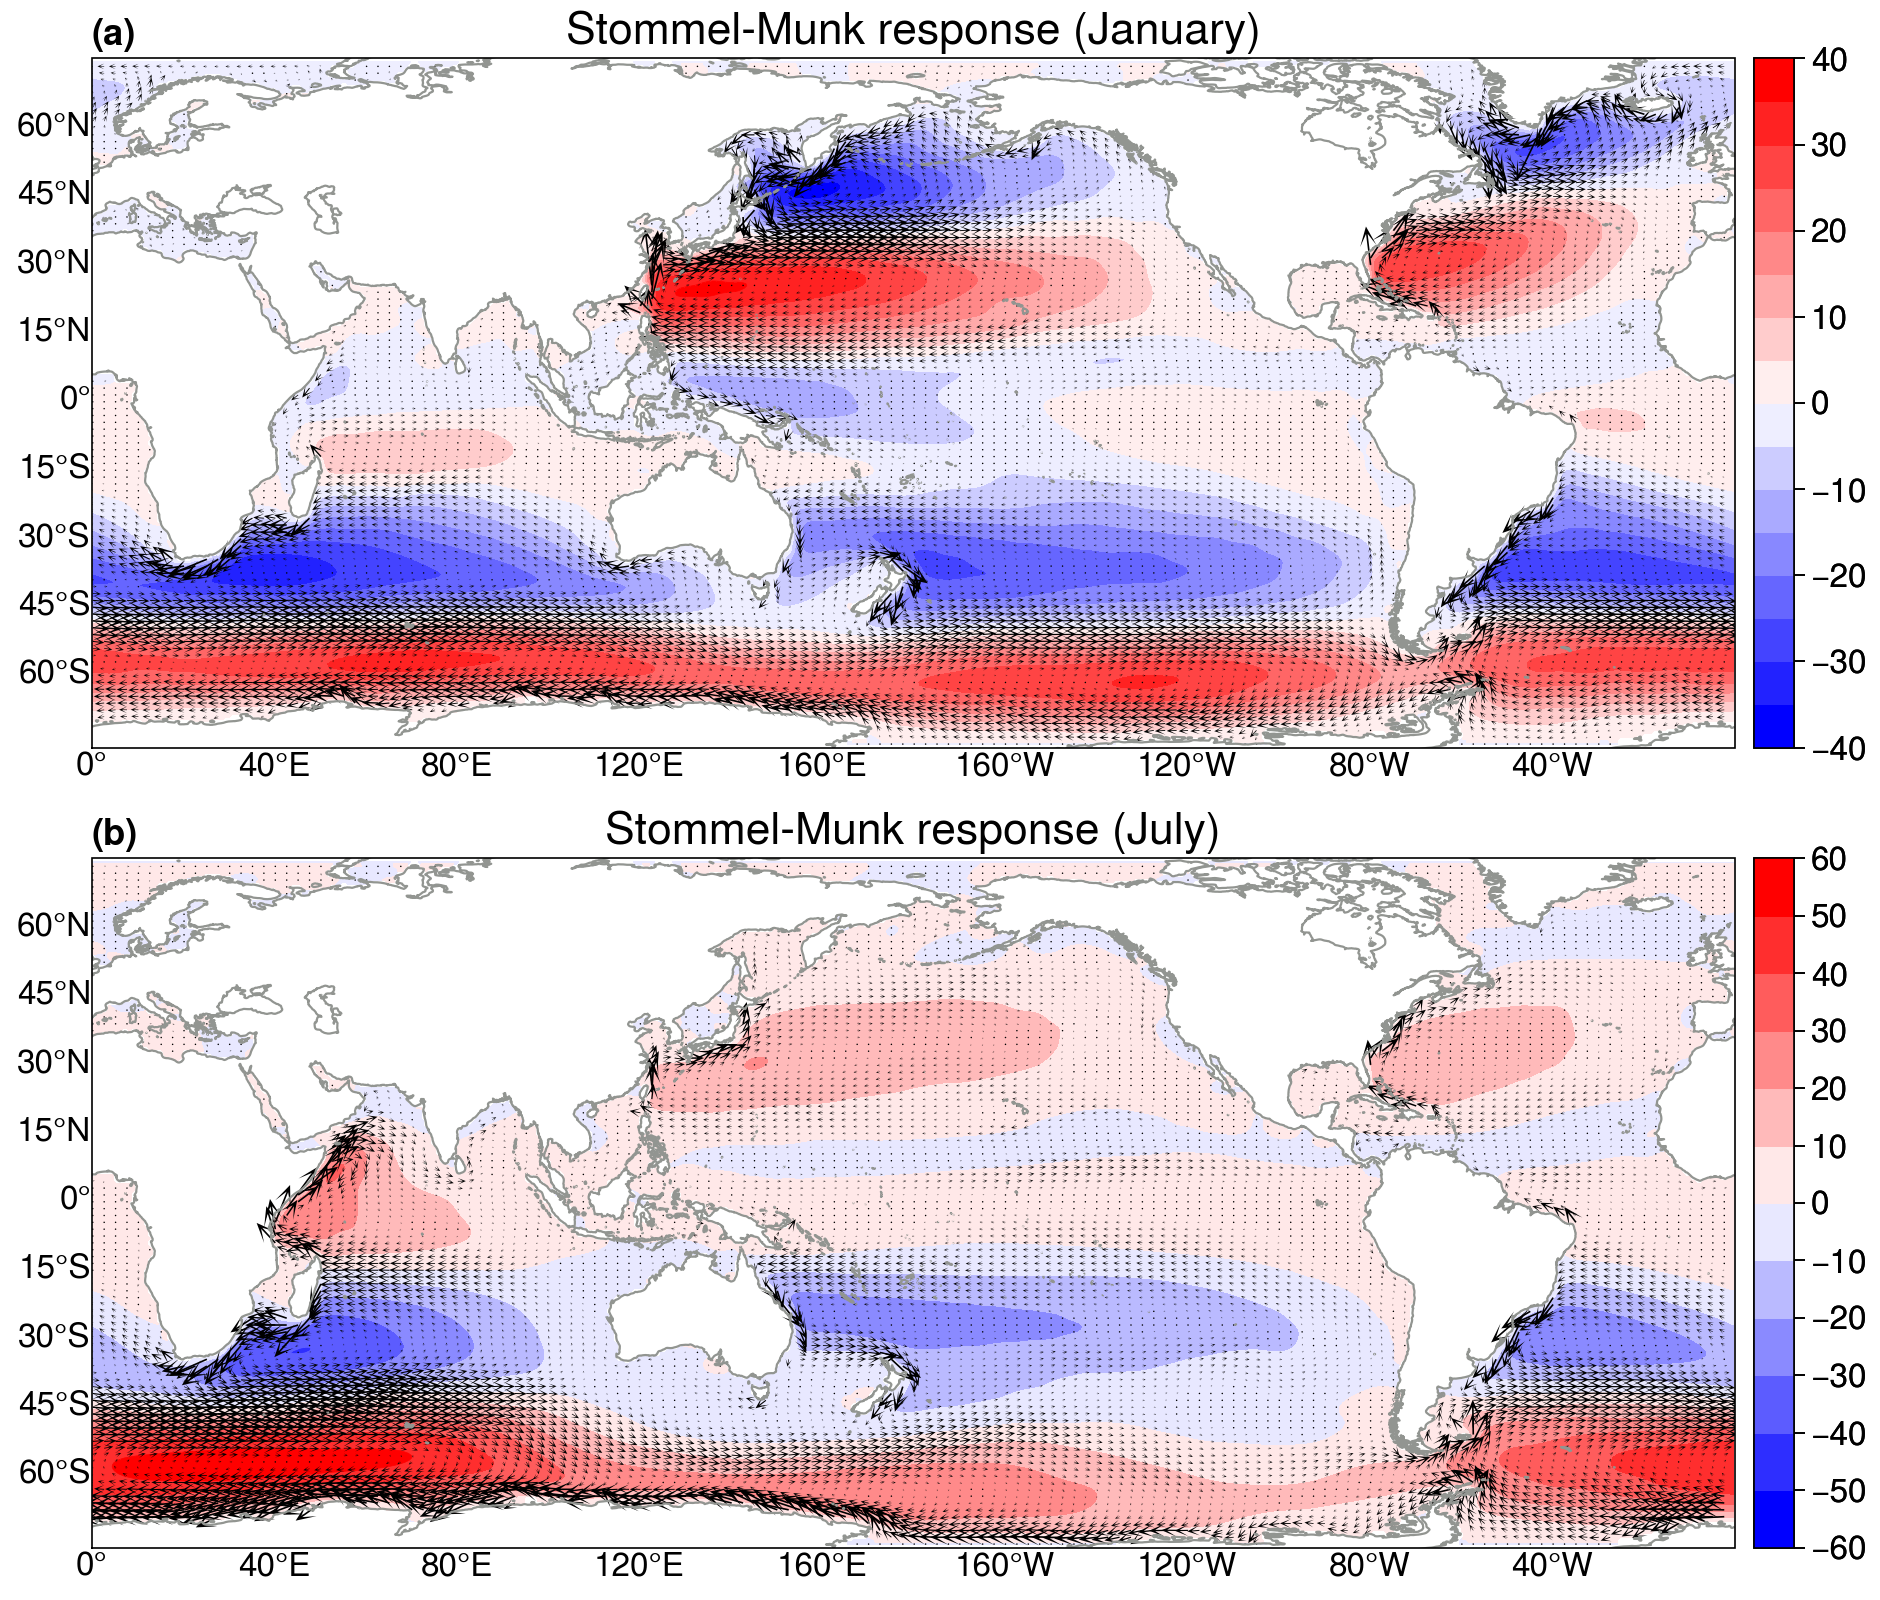

In [29]:
lat, lon = xr.broadcast(u1.lat, u1.lon)

fig, axes = pplt.subplots(nrows=2, ncols=1, figsize=(9.4,8), sharex=3, sharey=3, proj=pplt.Proj('cyl', lon_0=180))

skip = 3
fontsize = 16

axes.format(abc='(a)', coast=True, lonlines=40, latlines=15, lonlabels='b', latlabels='l', grid=False, labels=False)

ax = axes[0,0]
p=ax.contourf(h1/1e6*depth, cmap='bwr', levels=np.linspace(-40,40,17))
ax.set_title('Stommel-Munk response (January)', fontsize=fontsize)
ax.quiver(lon.values[::skip,::skip+2], lat.values[::skip,::skip+2],
           u1.values[::skip,::skip+2],  v1.values[::skip,::skip+2],
           width=0.001, headwidth=10., headlength=12., scale=40)
ax.set_ylim([-76, 75])
ax.set_xlim([-180, 180])

ax.colorbar(p, loc='r', label='', ticks=10)

ax = axes[1,0]
p=ax.contourf(h2/1e6*depth, cmap='bwr', levels=np.linspace(-60,60,13))
ax.set_title('Stommel-Munk response (July)',
             fontsize=fontsize)
ax.quiver(lon.values[::skip,::skip+2], lat.values[::skip,::skip+2],
           u2.values[::skip,::skip+2], v2.values[::skip,::skip+2],
           width=0.001, headwidth=10., headlength=12., scale=40)
ax.set_ylim([-76, 75])
ax.set_xlim([-180, 180])
ax.colorbar(p, loc='r', label='', ticks=10)


Striking features are the weakening of the gyre circulation over the northern hemisphere in July and strengthening of the Somali jet over the Indian Ocean.

---

### References
1. Munk, W., 1950: [On the wind-driven ocean circulation.](https://journals.ametsoc.org/view/journals/atsc/7/2/1520-0469_1950_007_0080_otwdoc_2_0_co_2.xml) *Journal of Meteorology*, **7**, 79-93.
2. Stommel, H., 1948: [The westward intensification of wind‐driven ocean currents.](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/TR029i002p00202) *Eos, Transactions American Geophysical Union*, **29**, 202-206.